In [ ]:
done=False
trainPath="drive/MyDrive/twitter/onechunk/trainCu.bz2"
destinationPath="drive/MyDrive/twitter/onechunk/"

#Setup

In [ ]:
%env PYTHONPATH=
!nvidia-smi
!echo $PYTHONPATH
#OK=>T4, V100


env: PYTHONPATH=
Mon Apr 26 11:25:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                       

In [ ]:
if done:
    assert(0==1)
!git clone https://github.com/rapidsai/rapidsai-csp-utils
!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.18
done=True

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 213 (delta 22), reused 3 (delta 0), pack-reused 171
Receiving objects: 100% (213/213), 64.29 KiB | 12.86 MiB/s, done.
Resolving deltas: 100% (84/84), done.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT SCRIPT CHANGES: Colab has updated to Python 3.7, and now runs our STABLE and NIGHTLY versions (0.18 and 0.19)!  PLEASE update your older install script code as follows:
	!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.18

	import sys, os

	dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
	sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
	sys.path
	exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), global

In [ ]:
import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

***********************************************************************
Let us check on those pyarrow and cffi versions...
***********************************************************************

You're don't have pyarrow.
unloaded cffi 1.14.5
loaded cffi 1.14.5


#Cugraph setup


In [ ]:
#import rmm 
import cudf 
import cugraph
import os
#rmm.reinitialize(managed_memory=True)
#assert(rmm.is_initialized())

In [ ]:
os.system(f"cp {trainPath} trainCu.bz2")

0

In [ ]:
!bunzip2 trainCu.bz2
!mv trainCu trainCu.csv

In [ ]:
e_list = cudf.read_csv("trainCu.csv", delimiter=',',index_col=0)

In [ ]:
e_list.head()

engaged_with_user_id  ... interactions
0                                     ...             
2   03EA05E7440140ABF047BC216CE34917  ...            1
4   B7E441F2D886830FB3F0CE29CB35CB6B  ...            1
7   223797E039AFAC669C3A24A43B59CD5E  ...            1
11  503B6E875783CABBC0F4CB7FEEA54622  ...            1
12  D77A8DF6804617BFD165C4A11304A27A  ...            1

[5 rows x 3 columns]

#katz_centrality

In [ ]:
G = cugraph.Graph()
G.from_cudf_edgelist(e_list, source='engaging_user_id', destination='engaged_with_user_id',edge_attr='interactions')

In [ ]:
pr_df = cugraph.katz_centrality(G)

In [ ]:
pr_df.columns

Index(['katz_centrality', 'vertex'], dtype='object')

In [ ]:
print(pr_df.head(10))

In [ ]:
pr_df.to_csv("katz_centrality.csv")
os.system(f"cp katz_centrality.csv '{destinationPath}katz_centrality.csv'")

0

In [ ]:
del pr_df
del G

#Pagerank

In [ ]:
G = cugraph.Graph()
G.from_cudf_edgelist(e_list, source='engaging_user_id', destination='engaged_with_user_id',edge_attr='interactions')

In [ ]:
pr_df = cugraph.pagerank(G, tol=1e-4)

In [ ]:
pr_sorted_df = pr_df.sort_values('pagerank',ascending=False)

In [ ]:
pr_sorted_df.columns

Index(['pagerank', 'vertex'], dtype='object')

In [ ]:
print(pr_sorted_df.head(10))

         pagerank                            vertex
1131207  0.000280  1DE5D18797E212A3850C5FB5C35E12E2
1519173  0.000207  B4246E7A34B52630ED396609E307F784
140261   0.000189  9C3AAFC3C2C2F129065F4BB5B00426B4
1511093  0.000184  F050BCE6C6A405C11C8D7897017CE1C1
1174528  0.000171  D956CB05C8566B63F75C86A595A84417
1164273  0.000169  4667DCB1BEDE5DDBEC118EEC9FA9990C
1504425  0.000166  6792C78666C4245899A8F4A767A611A6
1463917  0.000162  71BD68619B00ED3570E026CB9C667681
1255560  0.000161  CA84484A1D010A58A4FB9C6DFCCD89A7
1168978  0.000154  D3B95A15E887A09A5120A6748EC0A9D3


In [ ]:
pr_sorted_df.to_csv("pagerank.csv")
os.system(f"cp pagerank.csv {destinationPath}pagerank.csv")

0

In [ ]:
del pr_sorted_df
del pr_df
del G

#Hits

In [ ]:
G = cugraph.Graph()
G.from_cudf_edgelist(e_list, source='engaging_user_id', destination='engaged_with_user_id',edge_attr='interactions')

In [ ]:
hits_df = cugraph.hits(G, tol=1e-4)

In [ ]:
hits_df.columns

Index(['hubs', 'authorities', 'vertex'], dtype='object')

In [ ]:
print(hits_df.head(10))

           hubs   authorities                            vertex
0  1.165709e-09  1.165716e-09  02FA3E768BA51EE08AA9D098ED079482
1  3.879835e-12  3.879881e-12  B47FCA079E5D01F901B819ECE263F1DD
2  0.000000e+00  0.000000e+00  E36A5DA720EF476EC61F79B753CCEDA5
3  7.597836e-14  7.598496e-14  15FCC988F9C819109E20D31BE923A578
4  2.612996e-11  2.613013e-11  98C1837F4BAA52B93B45E0AF8C375C2F
5  5.931779e-12  5.931815e-12  D0A206603A1CB571B4BED58D028EB2C2
6  1.521696e-12  1.521715e-12  D5AADCFB69EF43CA9D1429A3EA52BF90
7  1.218685e-15  1.218699e-15  C8C131E0A09F97896C4E300A830B3069
8  1.415950e-09  1.415957e-09  A3DD0E11A77DDE97E3E3373D959A1272
9  0.000000e+00  0.000000e+00  08C2CB9E02FAD607D8CD7F1624DBEBB4


In [ ]:
hits_df.to_csv("hits.csv")
os.system(f"cp hits.csv '{destinationPath}hits.csv'")

0

In [ ]:
del hits_df
del G

#Jaccard

##Jaccard engaging to engaged

In [ ]:
G = cugraph.Graph()
G.from_cudf_edgelist(e_list, source='engaging_user_id', destination='engaged_with_user_id',edge_attr='interactions')


df = cugraph.jaccard_w(G, e_list['interactions'])

In [ ]:
del G

In [ ]:
jk_sorted_df = df.sort_values('jaccard_coeff',ascending=False)

In [ ]:
jk_sorted_df[:5]

jaccard_coeff  ...                       destination
263536        0.666667  ...  06C5FD59BD965EE20CBA4F7D4D7F7859
280054        0.666667  ...  EC478D67017FCEF8CA658CA3CECE2C47
306050        0.666667  ...  62AF7A8F6A3DA4B3FDE7D0FBDE1477FA
917929        0.666667  ...  B3733C09AD13E0B01D0134FB3CCAFE44
1321244       0.666667  ...  CD33A2E2CC5284196899F5CC87E74D11

[5 rows x 3 columns]

In [ ]:
jk_sorted_df=jk_sorted_df.query("jaccard_coeff > 0")

In [ ]:
del df

In [ ]:
jk_sorted_df[-5:]

jaccard_coeff  ...                       destination
1663227       0.001445  ...  785FB773AB220FC5C1A36988422AB58C
16592         0.001429  ...  D3B95A15E887A09A5120A6748EC0A9D3
1696671       0.001429  ...  2ACC64CA67BF140DD1A3767824735A92
434831        0.001282  ...  943107CD84CB3D5999678C9A429C6E96
2113246       0.001282  ...  130E8AD8D203C1A8422EDC6AE13F11B2

[5 rows x 3 columns]

In [ ]:
jk_sorted_df.to_csv("jaccard-ing-to-ed.csv")
os.system(f"cp jaccard-ing-to-ed.csv '{destinationPath}jaccard-ing-to-ed.csv'")

0

In [ ]:
del jk_sorted_df

##Jaccard opposite direction


In [ ]:
G = cugraph.Graph()
G.from_cudf_edgelist(e_list, destination='engaging_user_id', source='engaged_with_user_id',edge_attr='interactions')

df = cugraph.jaccard_w(G,e_list["interactions"])

In [ ]:
jk_sorted_df = df.sort_values('jaccard_coeff',ascending=False)

In [ ]:
jk_sorted_df[:5]

jaccard_coeff  ...                       destination
713697        0.666667  ...  1E310376604254152F0DDC60D0093347
2284025       0.666667  ...  5CB68E06FAF45602C095AE5964D2B4C2
554994        0.600000  ...  FAE7207C477F9B680174EDC501A76C44
1829080       0.600000  ...  DAA3B34033B99FC4BCCF456EEB073D40
458055        0.500000  ...  7D8560C4125CC618C34515689DD8D9E4

[5 rows x 3 columns]

In [ ]:
jk_sorted_df=jk_sorted_df.query("jaccard_coeff > 0")

In [ ]:
jk_sorted_df[-5:]

jaccard_coeff  ...                       destination
679493       0.002326  ...  D3B95A15E887A09A5120A6748EC0A9D3
12043        0.002309  ...  2ACC64CA67BF140DD1A3767824735A92
436372       0.002309  ...  D3B95A15E887A09A5120A6748EC0A9D3
49159        0.002165  ...  943107CD84CB3D5999678C9A429C6E96
56061        0.002165  ...  130E8AD8D203C1A8422EDC6AE13F11B2

[5 rows x 3 columns]

In [ ]:
jk_sorted_df.to_csv("jaccard-ed-to-ing.csv")
os.system(f"cp jaccard-ed-to-ing.csv '{destinationPath}jaccard-ed-to-ing.csv'")

0

In [ ]:
del jk_sorted_df
del df
del G

#Overlap

In [ ]:
G = cugraph.Graph()
G.from_cudf_edgelist(e_list, source='engaging_user_id', destination='engaged_with_user_id',edge_attr='interactions')

In [ ]:
over_df = cugraph.overlap(G)

In [ ]:
over_sorted_df = over_df.sort_values('overlap_coeff',ascending=False)

In [ ]:
over_sorted_df[:int(len(over_sorted_df)*0.2)].to_csv("over.csv")
os.system(f"cp over.csv '{destinationPath}over.csv'")

0

In [ ]:
del over_sorted_df
del over_df
del G

#Clustering

In [ ]:
ClusterCount=20

##spectralModularityMaximizationClusterin

###ing to ed

In [ ]:
G = cugraph.Graph()
G.from_cudf_edgelist(e_list, source='engaging_user_id', destination='engaged_with_user_id',edge_attr='interactions')

In [ ]:
clustering_ing = cugraph.spectralModularityMaximizationClustering(G, ClusterCount)

In [ ]:
clustering_ing.to_csv("clustering_ing.csv")
os.system(f'cp clustering_ing.csv "{destinationPath}spectralModularityMaximizationClusterin_ing{ClusterCount}.csv"')

0

In [ ]:
del G
del clustering_ing

###ed to ing

In [ ]:
G = cugraph.Graph()
G.from_cudf_edgelist(e_list, destination='engaging_user_id', source='engaged_with_user_id',edge_attr='interactions')

In [ ]:
clustering_ed = cugraph.spectralModularityMaximizationClustering(G, ClusterCount)

In [ ]:
clustering_ed.to_csv("clustering_ed.csv")
os.system(f'cp clustering_ed.csv "{destinationPath}spectralModularityMaximizationClusterin_ed{ClusterCount}.csv"')

0

In [ ]:
del G
del clustering_ed

##spectralBalancedCutClustering

###ing to ed

In [ ]:
G = cugraph.Graph()
G.from_cudf_edgelist(e_list, source='engaging_user_id', destination='engaged_with_user_id',edge_attr='interactions')

In [ ]:
clustering_ing = cugraph.spectralBalancedCutClustering(G, ClusterCount)

In [ ]:
clustering_ing.to_csv("clustering_ing.csv")
os.system(f'cp clustering_ing.csv "{destinationPath}spectralBalancedCutClustering_ing{ClusterCount}.csv"')

0

In [ ]:
del G
del clustering_ing

###ed to ing

In [ ]:
G = cugraph.Graph()
G.from_cudf_edgelist(e_list, destination='engaging_user_id', source='engaged_with_user_id',edge_attr='interactions')

In [ ]:
clustering_ed = cugraph.spectralBalancedCutClustering(G, ClusterCount)

In [ ]:
clustering_ed.to_csv("clustering_ed.csv")
os.system(f'cp clustering_ed.csv "{destinationPath}spectralBalancedCutClustering_ed{ClusterCount}.csv"')

0

In [ ]:
del G
del clustering_ed

##ECG

###ing to ed

In [ ]:
G = cugraph.Graph()
G.from_cudf_edgelist(e_list, source='engaging_user_id', destination='engaged_with_user_id',edge_attr='interactions')

In [ ]:
clustering_ing = cugraph.ecg(G,weight='interactions')

In [ ]:
clustering_ing.to_csv("ecg.csv")
os.system(f'cp ecg.csv "{destinationPath}ecg_ing.csv"')

0

In [ ]:
del G
del clustering_ing

###ed to ing

In [ ]:
G = cugraph.Graph()
G.from_cudf_edgelist(e_list, destination='engaging_user_id', source='engaged_with_user_id',edge_attr='interactions')

In [ ]:
clustering_ed = cugraph.ecg(G,weight='interactions')

In [ ]:
clustering_ed.to_csv("ecg_ed.csv")
os.system(f'cp ecg_ed.csv "{destinationPath}ecg_ed.csv"')

0

In [ ]:
del G
del clustering_ed

##Leiden

###ing to ed

In [ ]:
G = cugraph.Graph()
G.from_cudf_edgelist(e_list, source='engaging_user_id', destination='engaged_with_user_id',edge_attr='interactions')

In [ ]:
clustering_ing,_ = cugraph.leiden(G)

In [ ]:
clustering_ing.to_csv("leiden.csv")
os.system(f'cp leiden.csv "{destinationPath}leiden_ing.csv"')

0

In [ ]:
del G
del clustering_ing

###ed to ing

In [ ]:
G = cugraph.Graph()
G.from_cudf_edgelist(e_list, destination='engaging_user_id', source='engaged_with_user_id',edge_attr='interactions')

In [ ]:
clustering_ed,_ = cugraph.leiden(G)

In [ ]:
clustering_ed.to_csv("leiden_ed.csv")
os.system(f'cp leiden_ed.csv "{destinationPath}leiden_ed.csv"')

0

In [ ]:
del G
del clustering_ed

##louvain

###ing to ed

In [ ]:
G = cugraph.Graph()
G.from_cudf_edgelist(e_list, source='engaging_user_id', destination='engaged_with_user_id',edge_attr='interactions')

In [ ]:
clustering_ing,_ = cugraph.louvain(G)

In [ ]:
clustering_ing.to_csv("louvain.csv")
os.system(f'cp louvain.csv "{destinationPath}louvain_ing.csv"')

0

In [ ]:
del G
del clustering_ing

###ed to ing

In [ ]:
G = cugraph.Graph()
G.from_cudf_edgelist(e_list, destination='engaging_user_id', source='engaged_with_user_id',edge_attr='interactions')

In [ ]:
clustering_ed,_ = cugraph.leiden(G)

In [ ]:
clustering_ed.to_csv("louvain_ed.csv")
os.system(f'cp louvain_ed.csv "{destinationPath}louvain_ed.csv"')

0

In [ ]:
del G
del clustering_ed

#ConnectedParts

In [ ]:
G = cugraph.Graph()
G.from_cudf_edgelist(e_list, destination='engaging_user_id', source='engaged_with_user_id',edge_attr='interactions')

In [ ]:
df = cugraph.connected_components(G, connection="weak")

In [ ]:
df.to_csv("connectedPart.csv")
os.system(f'cp connectedPart.csv "{destinationPath}connectedPart.csv"')

0

#Visualization

##Visualization ing to ed

In [ ]:
G = cugraph.Graph()
G.from_cudf_edgelist(e_list, source='engaging_user_id', destination='engaged_with_user_id',edge_attr='interactions')

out=cugraph.force_atlas2(G)

In [ ]:
out.to_csv("atlas-ing-to-ed.csv")
os.system(f"cp atlas-ing-to-ed.csv '{destinationPath}atlas-ing-to-ed.csv'")

0

In [ ]:
out.head()

x            y                            vertex
0  2.496928e+05  2061921.375  ABBF3398DAFF07CB7448241EF347B804
1 -1.925712e+06 -2563809.750  695F058092ADD3FEB3C6D1523B2BA735
2 -1.110725e+06  1591005.625  31550D230E9FEFAD71CF0CC20BBCC13E
3  1.422304e+06 -2079491.625  629BA78171CC2D1FC4B405C017E4EF27
4 -1.013793e+05  1528480.000  B8438D81C70B4EFAF4A920668D675D6B

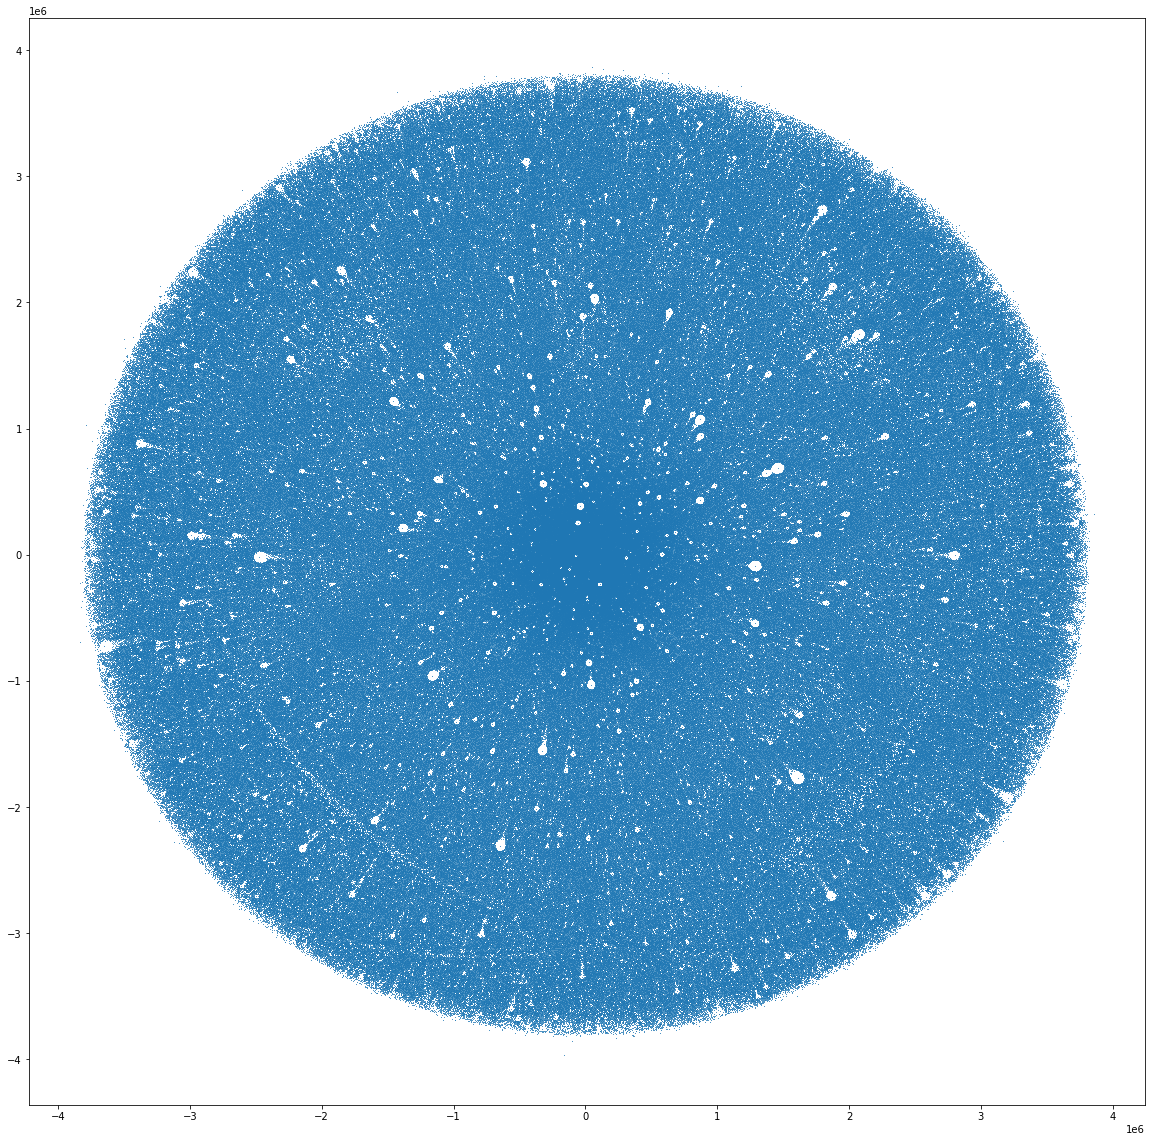

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig,ax=plt.subplots(figsize=(20,20))
x=out['x'].to_arrow().to_pylist()
y=out['y'].to_arrow().to_pylist()
plt.scatter(x,y,s=1, 
                linewidth=0)
plt.show()

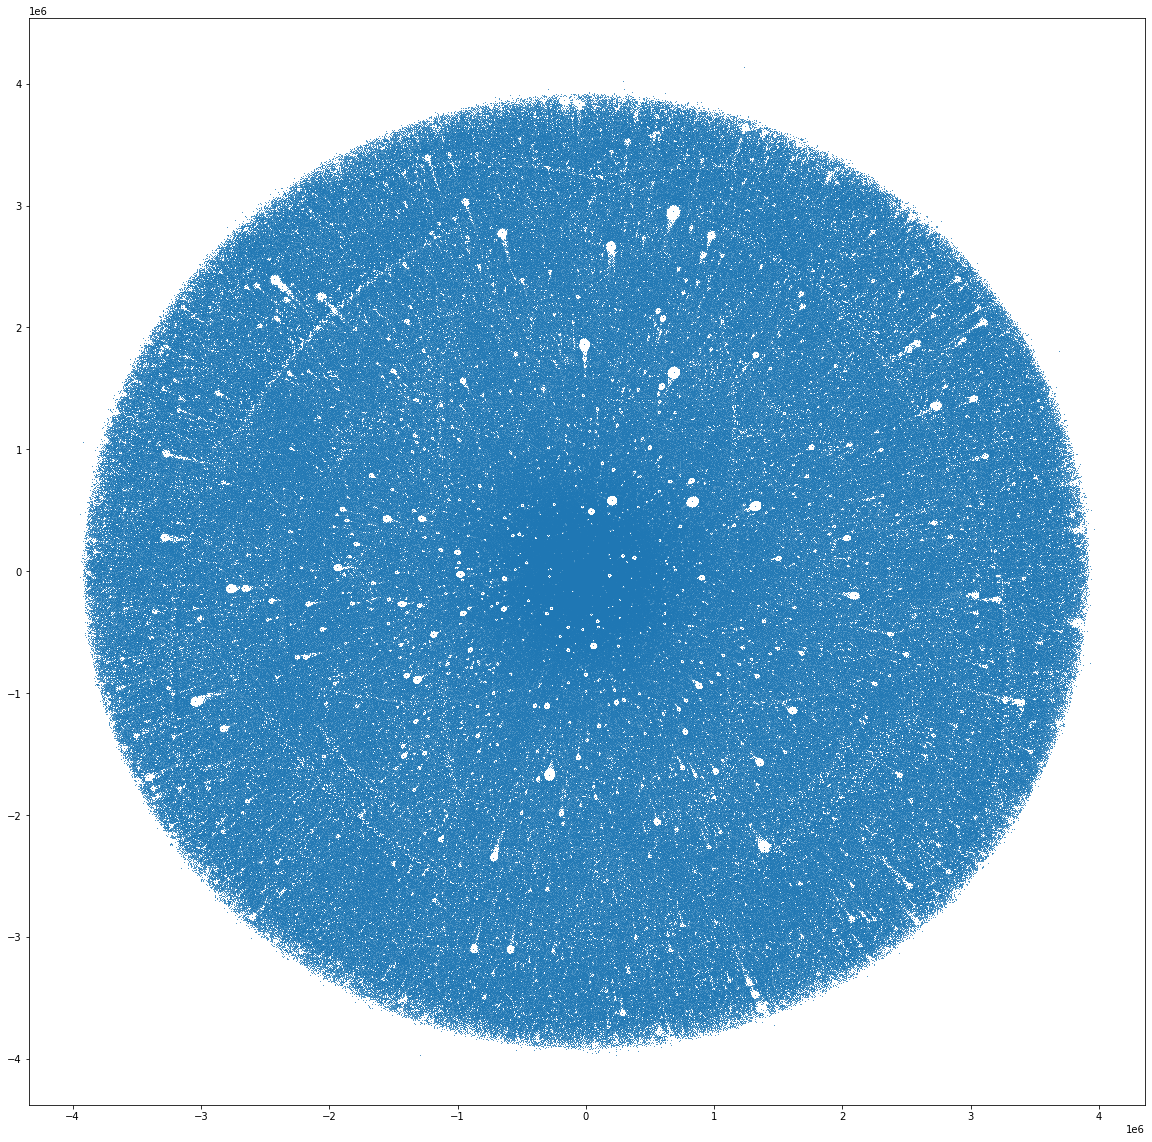

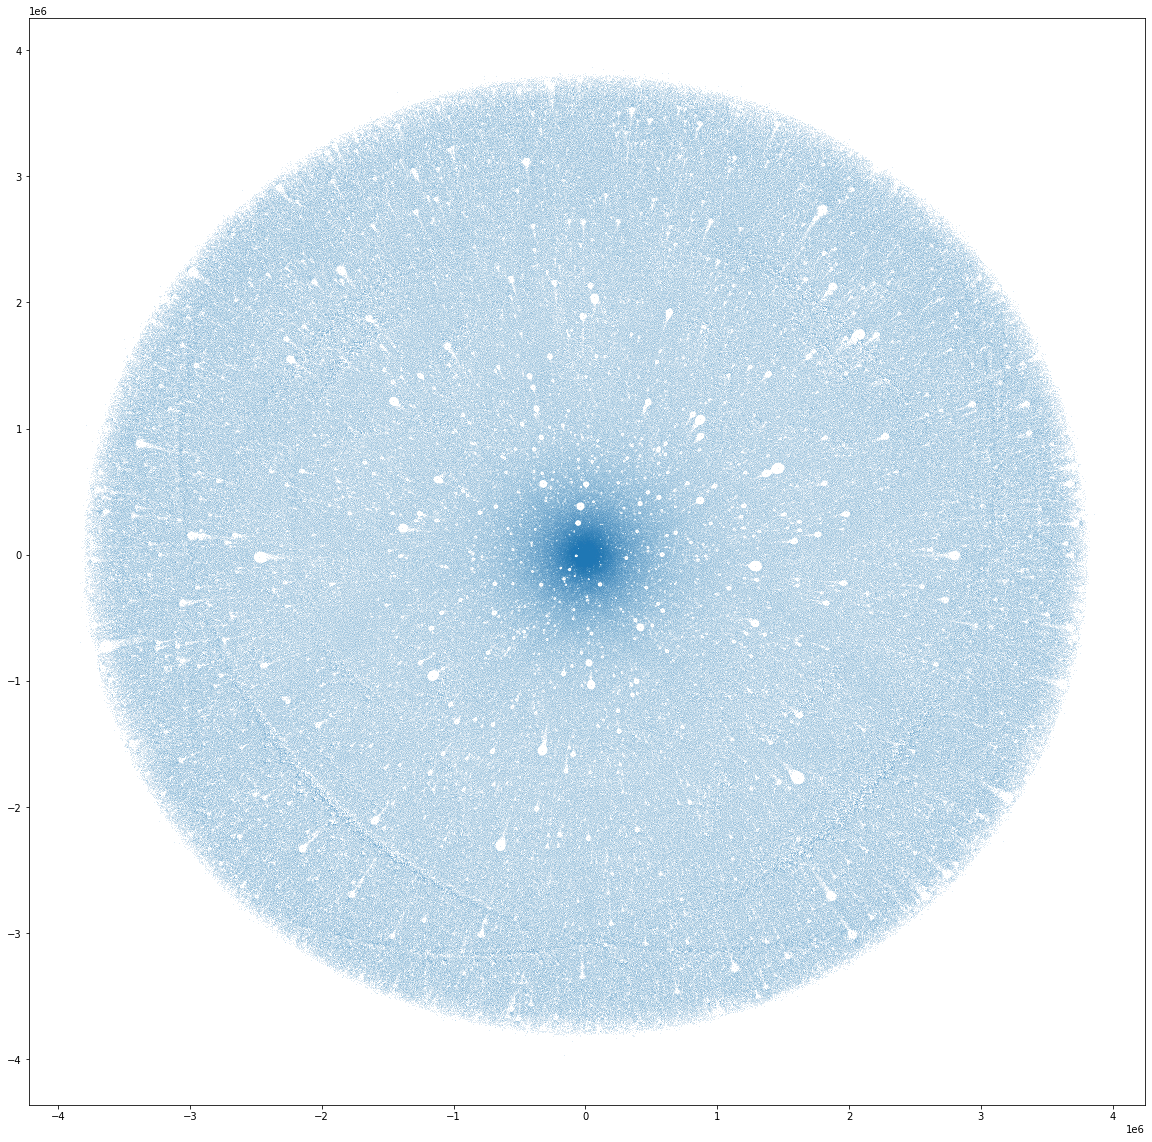

In [ ]:
fig,ax=plt.subplots(figsize=(20,20))
plt.scatter(x,y,s=0.1, 
                linewidth=0)
plt.show()

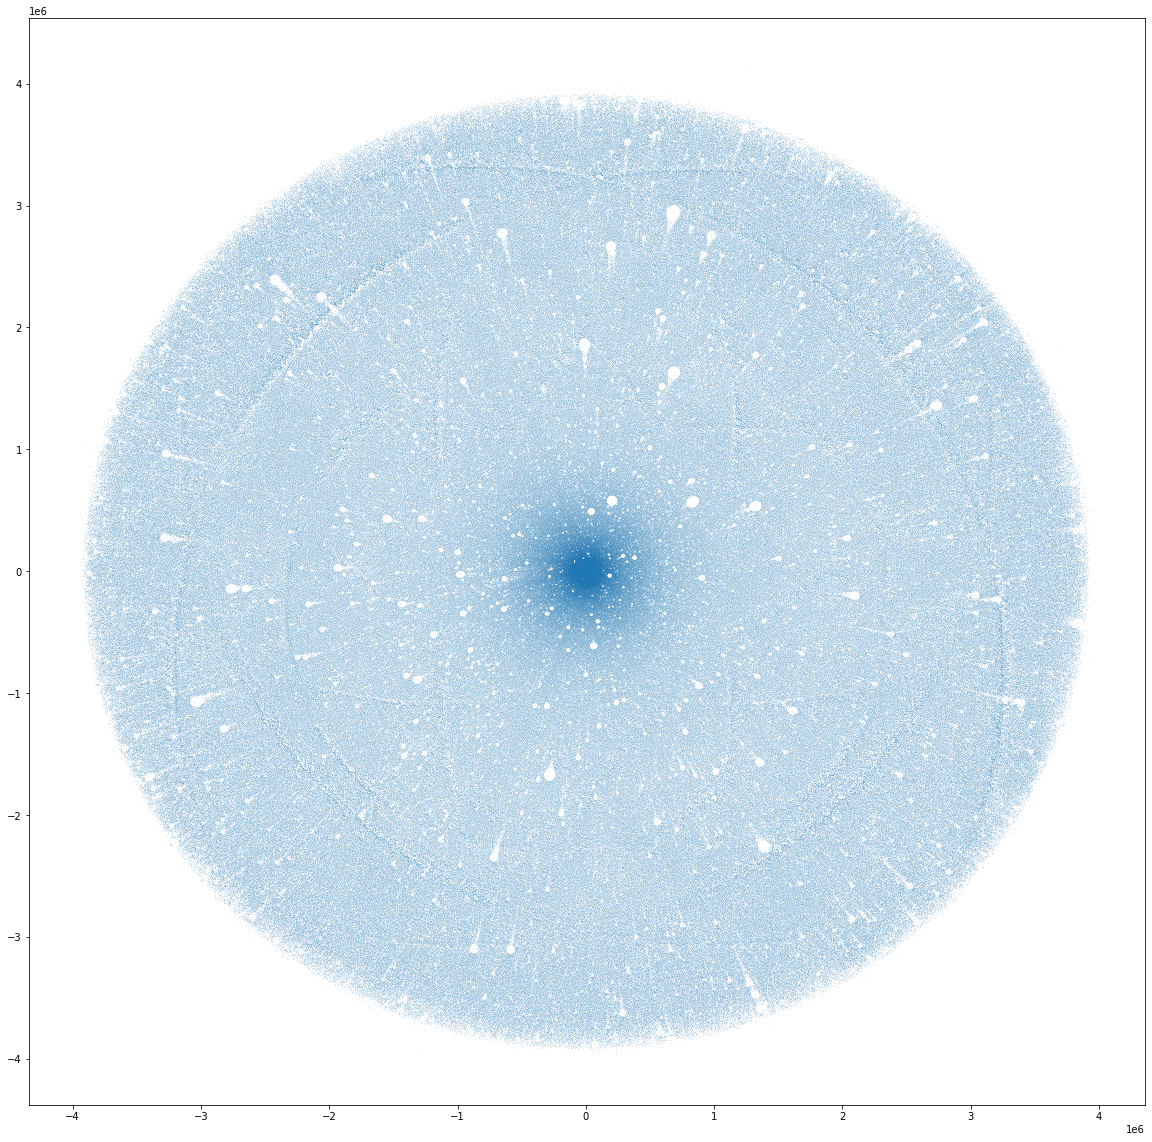

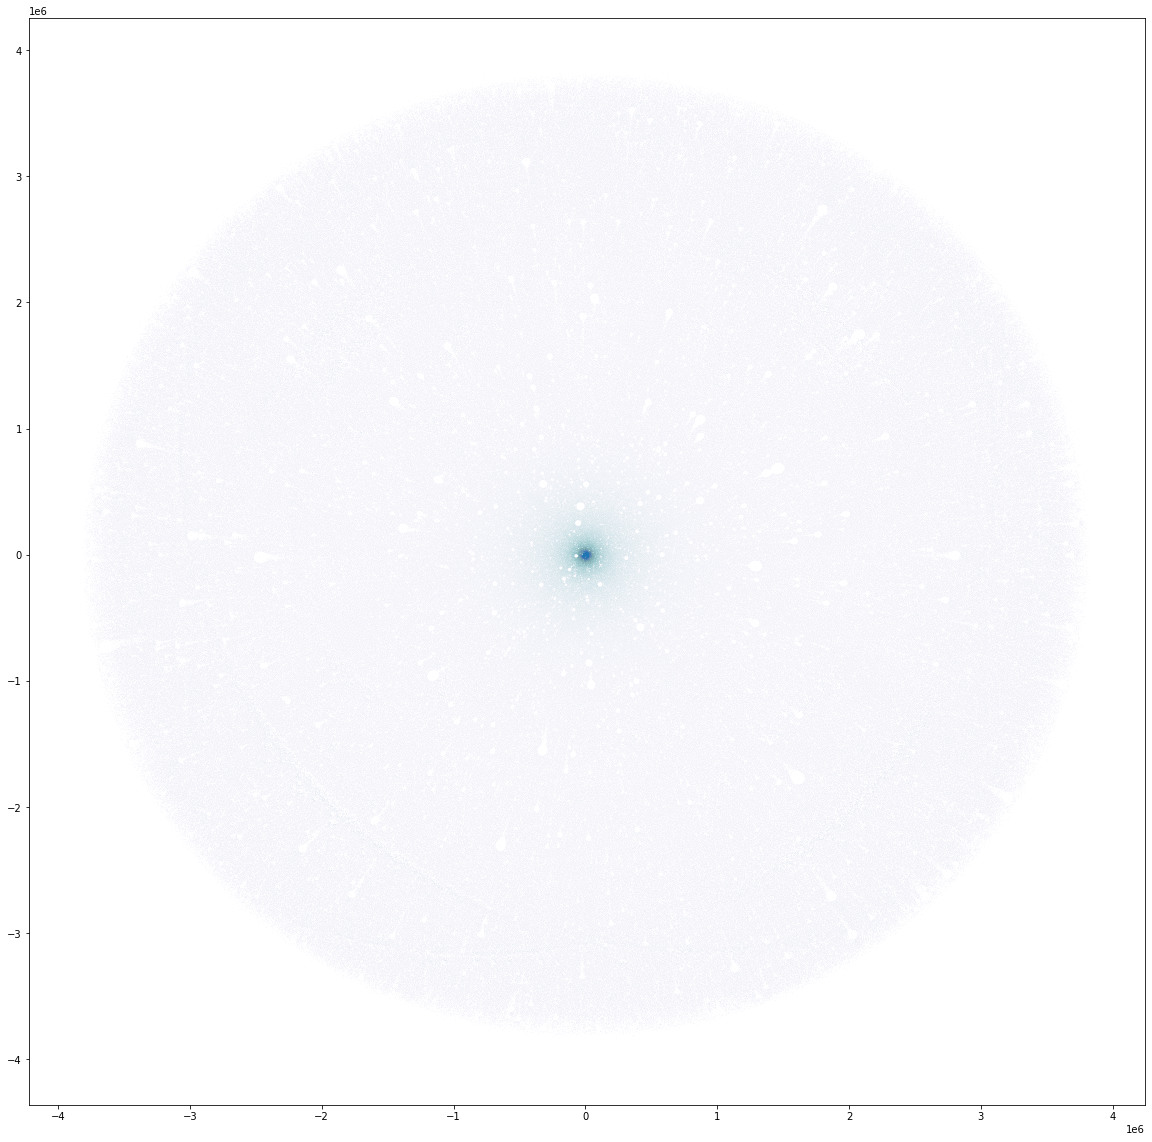

In [ ]:
fig,ax=plt.subplots(figsize=(20,20))
plt.scatter(x,y,s=0.01, 
                linewidth=0)
plt.show()

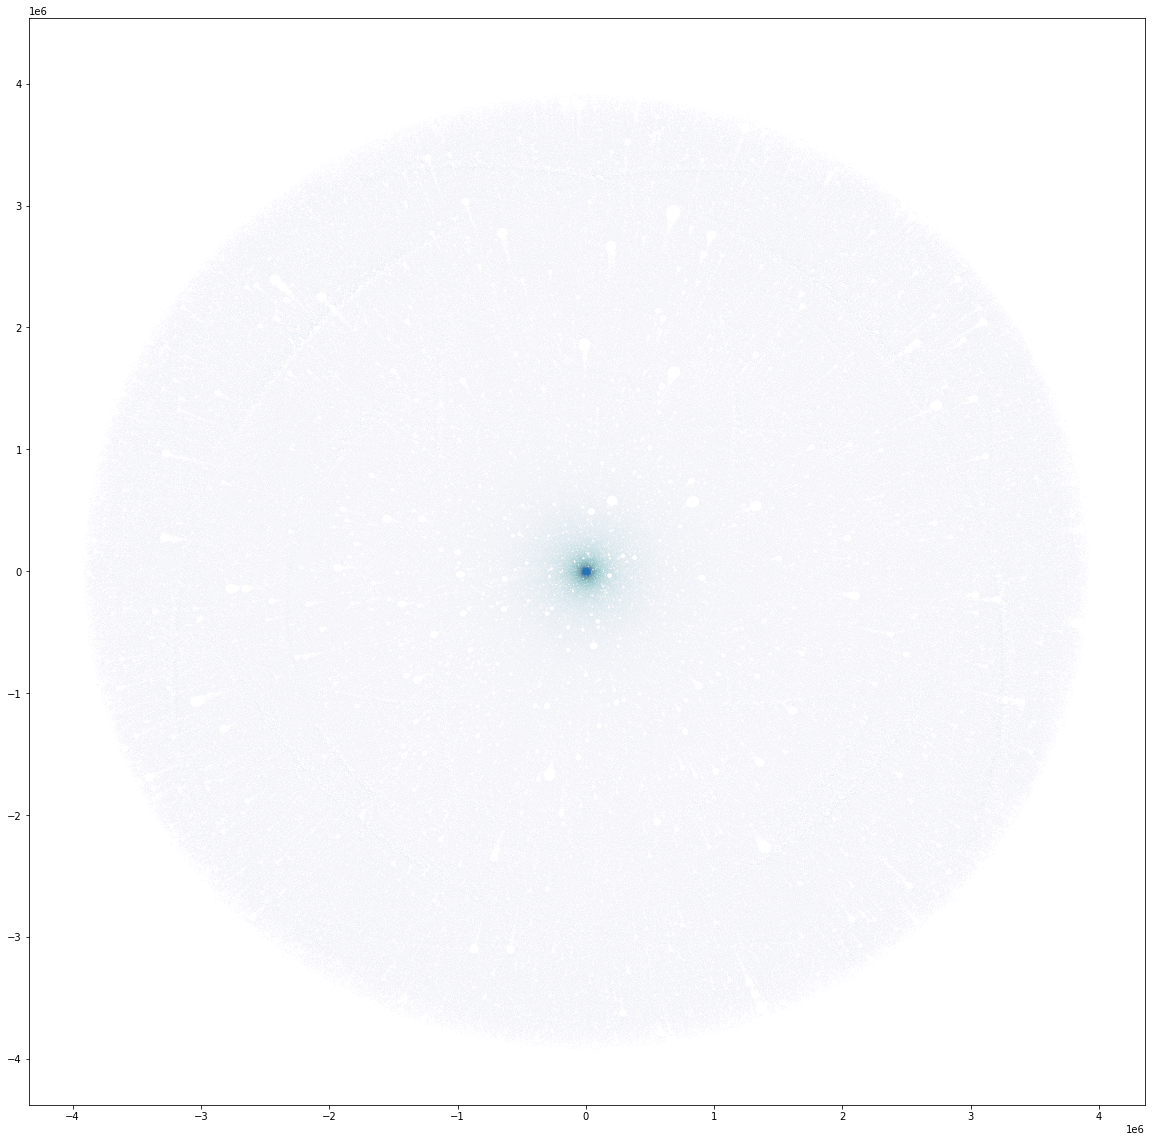

##Visualization ed to ing

In [ ]:
G = cugraph.Graph()
G.from_cudf_edgelist(e_list, destination='engaging_user_id', source='engaged_with_user_id',edge_attr='interactions')

out=cugraph.force_atlas2(G)

In [ ]:
out.to_csv("atlas-ed-to-ing.csv")
os.system(f"cp atlas-ed-to-ing.csv '{destinationPath}atlas-ed-to-ing.csv'")

In [ ]:
out.head()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig,ax=plt.subplots(figsize=(20,20))
x=out['x'].to_arrow().to_pylist()
y=out['y'].to_arrow().to_pylist()
plt.scatter(x,y,s=1, 
                linewidth=0)
plt.show()

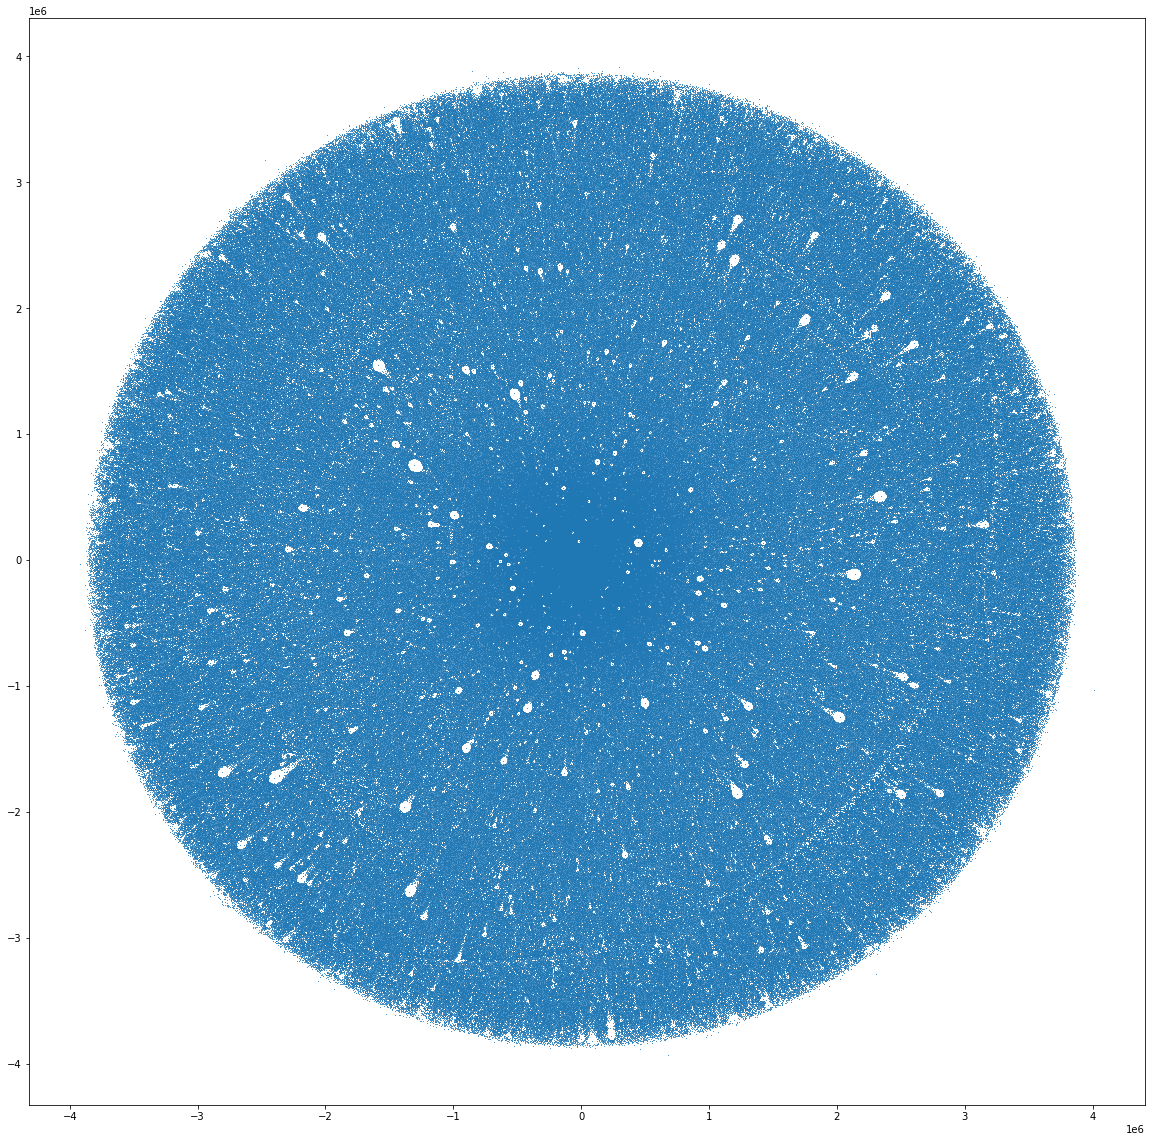

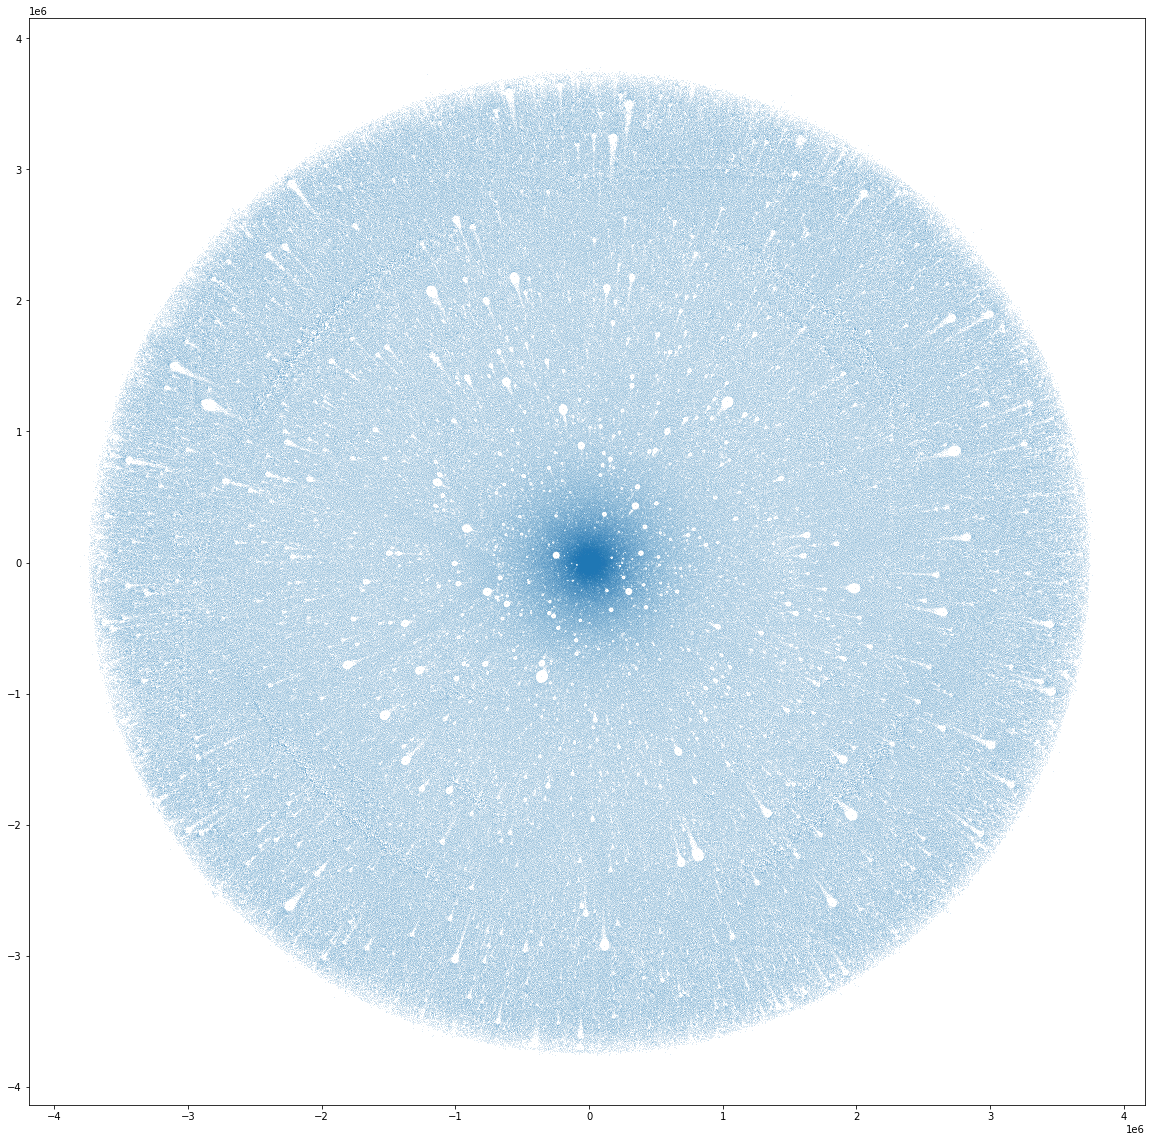

In [ ]:
fig,ax=plt.subplots(figsize=(20,20))
plt.scatter(x,y,s=0.1, 
                linewidth=0)
plt.show()

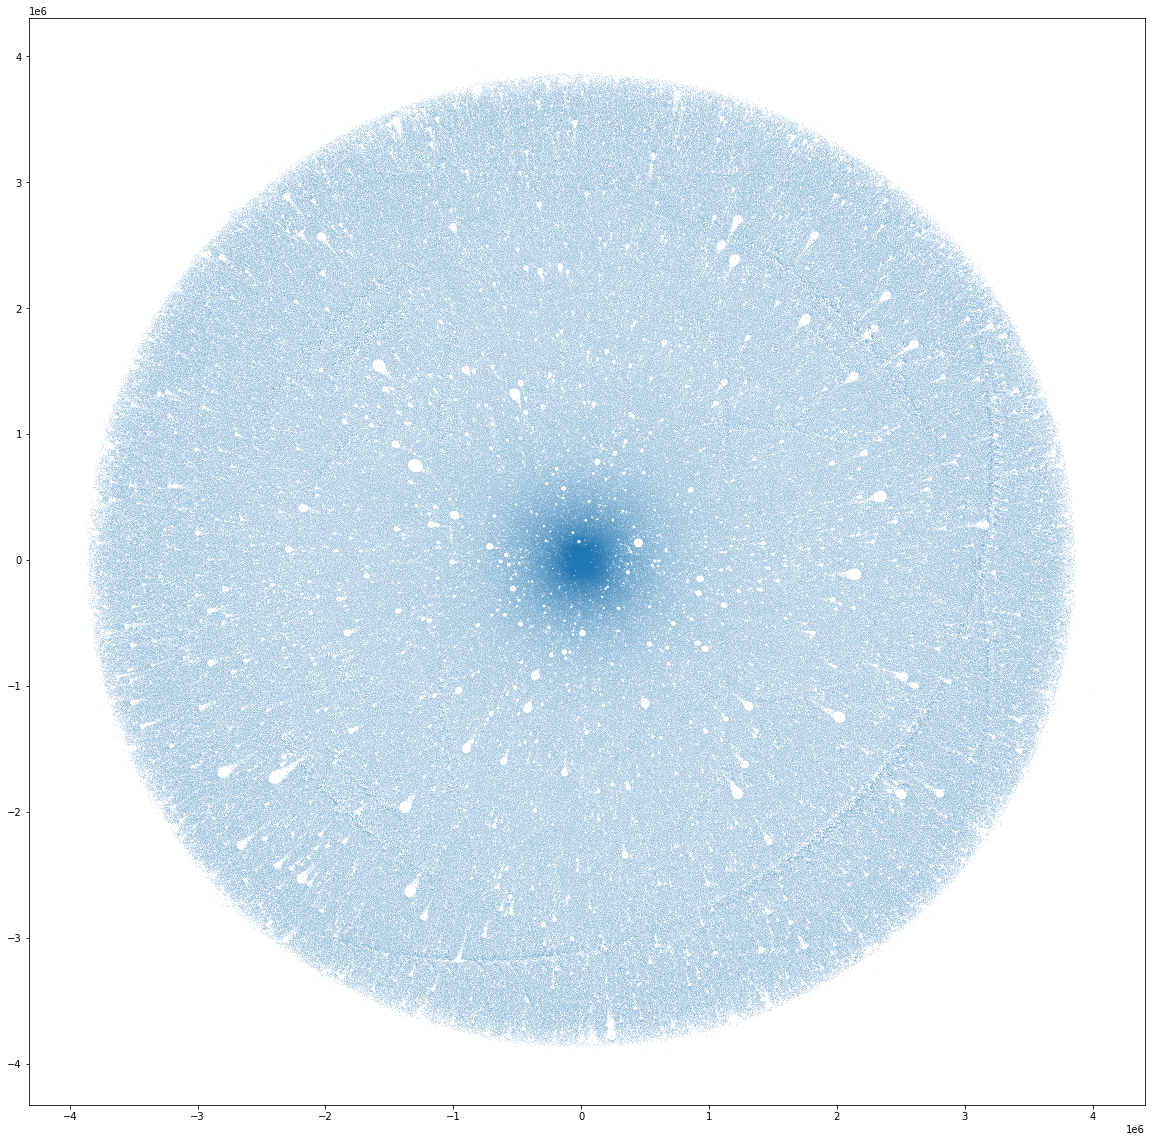

In [ ]:
fig,ax=plt.subplots(figsize=(20,20))
plt.scatter(x,y,s=0.01, 
                linewidth=0)
plt.show()

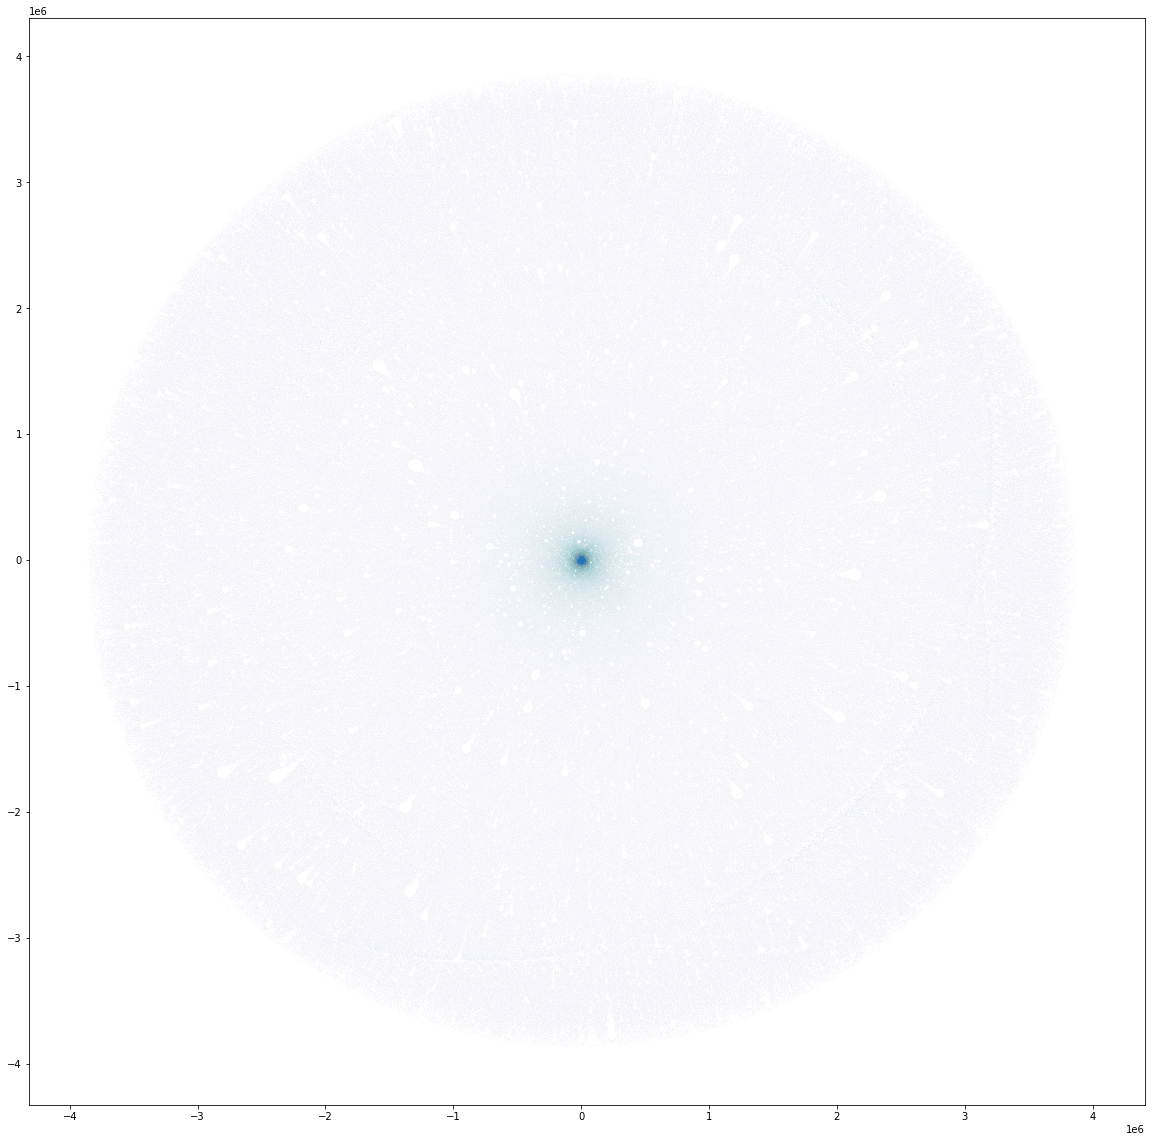

#Close On complete

In [ ]:
!kill -9 -1